<a href="https://colab.research.google.com/github/Bendeguzfrks04/DeepML/blob/main/Competition02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
!pip install torchsummary
!pip install efficientnet_pytorch
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import metrics
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from tqdm.autonotebook import tqdm
# Any results you write to the current directory are saved as output.

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=1fda482872d424842b4d322dd481fa0e98cef307710cdc782d75362f890934ed
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
#Check if your system supports CUDA
gpu_available = torch.cuda.is_available() # is_available returns a bool as true or false

if gpu_available:
    print('Training on GPU')
else:
    print('Training on CPU')

Training on GPU


In [ ]:
!unzip -q "/content/drive/MyDrive/train.zip" 
!unzip -q "/content/drive/MyDrive/test.zip" 

In [ ]:
'''
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 
from efficientnet import center_crop_and_resize, preprocess_input
'''

'\nimport os\n%cd /content\nif not os.path.isdir("efficientnet_keras_transfer_learning"):\n  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning\n%cd efficientnet_keras_transfer_learning/\n\n# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3\n# Higher the number, the more complex the model is.\nfrom efficientnet import EfficientNetB0 \nfrom efficientnet import center_crop_and_resize, preprocess_input\n'

In [ ]:
#parameters
batch_size = 64
im_size = 150

In [ ]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()
im_size = 150
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = "/content/train", transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
mean,std = normalization_parameter(train_loader)

In [ ]:
#image transformations for train and test data

train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

#inverse normalization for image plot
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

In [ ]:
def data_loader(train_data, test_data = None, valid_size = None, batch_size = 32):
    train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
    if(test_data == None and valid_size == None):
        dataloaders = {'train':train_loader}
        return dataloaders
    if(test_data == None and valid_size!=None):
        data_len = len(train_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        valid_loader = DataLoader(train_data, batch_size= batch_size, sampler=valid_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader}
        return dataloaders
    if(test_data != None and valid_size!=None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
        test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        return dataloaders

In [ ]:
#data loader
train_data = torchvision.datasets.ImageFolder(root = "/content/train", transform = train_transforms)
#testset = datasets.ImageFolder(root = "/content/test/", transform = test_transforms)
dataloaders = data_loader(train_data, test_data=None , valid_size = 0.2 , batch_size = batch_size)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
#label of classes
classes = train_data.classes
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 299, 299])
torch.Size([64])


TypeError: ignored

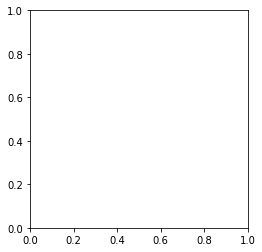

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


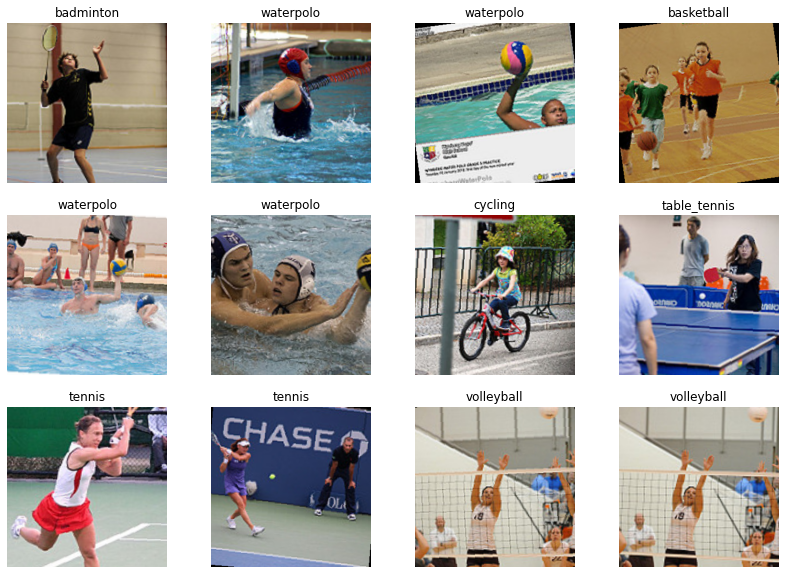

In [ ]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

In [ ]:
#using efficientnet model based transfer learning
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet =  EfficientNet.from_pretrained('efficientnet-b0')
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.75)
        self.l2 = nn.Linear(256,6)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
# defining the model
model = Classifier()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Loaded pretrained weights for efficientnet-b0
Classifier(
  (resnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (stat

In [ ]:
for i in range(10):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

RuntimeError: ignored

In [ ]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))a

NameError: ignored

In [ ]:
# Loss -> Negative log likelihood loss if output layer logsoftmax else for linear layer we use crossentropy loss.
criterion = nn.CrossEntropyLoss()
#lr scheduler ->
#learning rate half after 3 epochs
# cyclical learning rate ->
#Original learning rate restored after 10 epochs

In [ ]:
'''
a = "relu"
model = Sequential()
#pretrained_model = ResNet50(weights='imagenet'), 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(Conv2D(8, (3, 3), activation=a, input_shape = ( 256, 256, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(16, (3, 3), activation=a))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(32, (3, 3), activation=a))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(32, (3, 3), activation=a))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation=a))
model.add(Dropout(0.4))
model.add(Dense(10, activation="softmax"))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(layers.Dense(10, activation="softmax"))
'''
model = Classifier()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.summary()

Loaded pretrained weights for efficientnet-b0


AttributeError: ignored

In [ ]:
#history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))
history = model.fit_generator(train_generator, epochs=10, validation_data=valid_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10


NotFoundError: ignored

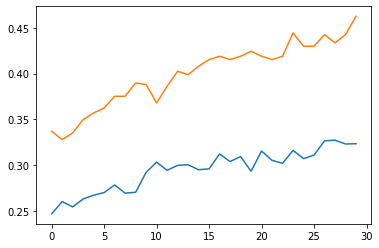

In [ ]:
plt.plot(history.epoch, history.history["acc"])
plt.plot(history.epoch, history.history["val_acc"])

In [ ]:
predictions = model.predict_generator(test_generator) # And this is how you predict

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
import numpy as np
print(predictions)
print()
print(np.argmax(predictions, axis=1)) # Argmax grabs the most probable sport for each image

[[1.13203865e-03 1.71528861e-03 6.55829161e-02 ... 8.57849140e-03
  3.89219850e-01 1.02447346e-01]
 [5.65822629e-05 2.59290129e-04 8.32369915e-06 ... 2.27915624e-08
  4.33462992e-04 1.64150752e-05]
 [1.22381933e-02 1.10195986e-09 2.87297599e-08 ... 1.08885416e-08
  4.55368543e-08 7.52567648e-05]
 ...
 [5.78688706e-08 2.71977155e-15 1.09889237e-13 ... 6.85234767e-08
  3.22960281e-09 9.99968052e-01]
 [5.19260493e-06 1.51643903e-07 7.08584927e-12 ... 2.43397320e-08
  1.70661139e-07 1.10292194e-06]
 [1.69347970e-07 1.56240091e-07 3.20888716e-06 ... 3.09310355e-10
  8.84096662e-05 1.53748516e-08]]

[5 5 3 ... 9 5 3]


In [ ]:
import pandas as pd
print(valid_generator.class_indices) #The class names are returned as a name-index mapping. We have to invert it
inv_map = {v: k for k, v in valid_generator.class_indices.items()}
print(inv_map)
submission = pd.DataFrame(data= {'ID': test_generator.filenames , 'sport' : np.argmax(predictions, axis=1)} )
submission = submission.replace(inv_map)
print(submission.head())
filename = 'Sports1.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

{'badminton': 0, 'basketball': 1, 'cycling': 2, 'ice_hockey': 3, 'running': 4, 'skiing': 5, 'table_tennis': 6, 'tennis': 7, 'volleyball': 8, 'waterpolo': 9}
{0: 'badminton', 1: 'basketball', 2: 'cycling', 3: 'ice_hockey', 4: 'running', 5: 'skiing', 6: 'table_tennis', 7: 'tennis', 8: 'volleyball', 9: 'waterpolo'}
                 ID       sport
0  test/1000002.jpg      skiing
1  test/1000417.jpg      skiing
2  test/1001734.jpg  ice_hockey
3  test/1001837.jpg  ice_hockey
4  test/1002845.jpg      skiing
Saved file: Sports1.csv
